In [1]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.

**Import libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import time

In [3]:
# Đọc dữ liệu từ file CSV
df = pd.read_csv('/kaggle/input/covertype-dataset/covertype/Covertype.csv')

# Kiểm tra dữ liệu
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (581012, 55)


,Cover_Type,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4
0,5,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,0
1,5,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,0
2,2,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,0
3,2,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,0
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# https://github.com/google-research/google-research/blob/master/tabnet/data_helper_covertype.py
NUMERIC_COLS = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways", "Hillshade_9am", "Hillshade_Noon",
    "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points"
]

BOOL_COLS = [col for col in df.columns if col.startswith("Wilderness_Area") or col.startswith("Soil_Type")]

# Ensure BOOL_COLS are integers
df[BOOL_COLS] = df[BOOL_COLS].astype(int)

# Final feature set
FEATURES = NUMERIC_COLS + BOOL_COLS
LABEL = 'Cover_Type'

In [5]:
# Cell 5: Prepare data and splits
X = df[FEATURES]
y = df[LABEL] - 1  # Labels from 0 to 6 for TabNet
# Stratified split: 80% train, 10% val, 10% test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1111, stratify=y_trainval, random_state=42)
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (464814, 54) Val: (58096, 54) Test: (58102, 54)


In [6]:
# Cell 6: Normalize only numerical columns (bool columns left as is)
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[NUMERIC_COLS])
X_val_num = scaler.transform(X_val[NUMERIC_COLS])
X_test_num = scaler.transform(X_test[NUMERIC_COLS])

# Combine numeric + bool back
X_train_scaled = np.hstack([X_train_num, X_train[BOOL_COLS].values])
X_val_scaled = np.hstack([X_val_num, X_val[BOOL_COLS].values])
X_test_scaled = np.hstack([X_test_num, X_test[BOOL_COLS].values])

In [7]:
# Cell 7: Prepare data for TabNet
X_train_np = X_train_scaled
X_val_np = X_val_scaled
X_test_np = X_test_scaled
y_train_np = y_train.values
y_val_np = y_val.values
y_test_np = y_test.values

In [8]:
# Train TabNet (paper-based configuration)
tabnet = TabNetClassifier(
    n_d=64,                     # Decision layer dimension
    n_a=64,                     # Attention embedding dimension
    n_steps=5,                  # Number of decision steps
    gamma=1.5,                  # Relaxation factor
    lambda_sparse=1e-4,         # Sparsity regularization
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),  # Learning rate
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params=dict(step_size=10, gamma=0.95),  # LR scheduler
    mask_type='sparsemax',      # Use sparsemax for interpretability
    device_name='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=1                   # Show training logs
)

# Fit TabNet
start = time.time()
tabnet.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_metric=['accuracy'],
    max_epochs=200,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)
tabnet_time = time.time() - start

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75477 | val_0_accuracy: 0.7205  |  0:00:28s
epoch 1  | loss: 0.63181 | val_0_accuracy: 0.75052 |  0:00:55s
epoch 2  | loss: 0.5833  | val_0_accuracy: 0.76902 |  0:01:22s
epoch 3  | loss: 0.53953 | val_0_accuracy: 0.78895 |  0:01:48s
epoch 4  | loss: 0.49802 | val_0_accuracy: 0.81809 |  0:02:15s
epoch 5  | loss: 0.44609 | val_0_accuracy: 0.83701 |  0:02:42s
epoch 6  | loss: 0.39559 | val_0_accuracy: 0.8628  |  0:03:09s
epoch 7  | loss: 0.34988 | val_0_accuracy: 0.8807  |  0:03:35s
epoch 8  | loss: 0.32309 | val_0_accuracy: 0.86462 |  0:04:02s
epoch 9  | loss: 0.31399 | val_0_accuracy: 0.89507 |  0:04:29s
epoch 10 | loss: 0.28503 | val_0_accuracy: 0.90664 |  0:04:56s
epoch 11 | loss: 0.2707  | val_0_accuracy: 0.91005 |  0:05:22s
epoch 12 | loss: 0.25924 | val_0_accuracy: 0.91056 |  0:05:48s
epoch 13 | loss: 0.25462 | val_0_accuracy: 0.91691 |  0:06:15s
epoch 14 | loss: 0.24527 | val_0_accuracy: 0.91836 |  0:06:41s
epoch 15 | loss: 0.2376  | val_0_accuracy: 0.9232  |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [9]:
#Evaluate TabNet
y_pred_tabnet = tabnet.predict(X_test_np)
acc_tabnet = accuracy_score(y_test_np, y_pred_tabnet)
f1_tabnet = f1_score(y_test_np, y_pred_tabnet, average='macro')
print("✅ TabNet Accuracy:", acc_tabnet)
print("✅ TabNet F1 Score:", f1_tabnet)
print("⏱ Train time: %.2f s" % tabnet_time)

✅ TabNet Accuracy: 0.9609135657980793
✅ TabNet F1 Score: 0.9351878691276585
⏱ Train time: 5370.52 s


In [10]:
#Train XGBoost
xgb = XGBClassifier(tree_method='hist', eval_metric='mlogloss', use_label_encoder=False)
start = time.time()
xgb.fit(X_train_scaled, y_train)
xgb_time = time.time() - start

In [11]:
#Evaluate XGBoost
y_pred_xgb = xgb.predict(X_test_scaled)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb, average='macro')
print("✅ XGBoost Accuracy:", acc_xgb)
print("✅ XGBoost F1 Score:", f1_xgb)
print("⏱ Train time: %.2f s" % xgb_time)

✅ XGBoost Accuracy: 0.8703314860073663
✅ XGBoost F1 Score: 0.8535140697221861
⏱ Train time: 25.96 s


In [12]:
#Train CatBoost
cat = CatBoostClassifier(verbose=0)
start = time.time()
cat.fit(X_train, y_train)
cat_time = time.time() - start

In [13]:
#Evaluate CatBoost
y_pred_cat = cat.predict(X_test)
acc_cat = accuracy_score(y_test, y_pred_cat)
f1_cat = f1_score(y_test, y_pred_cat, average='macro')
print("✅ CatBoost Accuracy:", acc_cat)
print("✅ CatBoost F1 Score:", f1_cat)
print("⏱ Train time: %.2f s" % cat_time)

✅ CatBoost Accuracy: 0.8852190974493133
✅ CatBoost F1 Score: 0.8516380544623267
⏱ Train time: 166.75 s


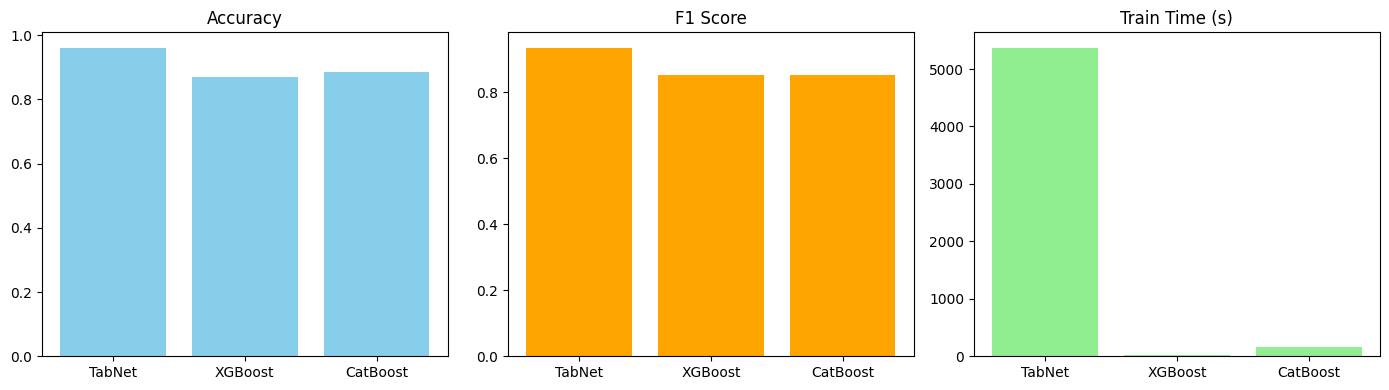

In [14]:
#So sánh kết quả
labels = ['TabNet', 'XGBoost', 'CatBoost']
accs = [acc_tabnet, acc_xgb, acc_cat]
f1s = [f1_tabnet, f1_xgb, f1_cat]
times = [tabnet_time, xgb_time, cat_time]

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.bar(labels, accs, color='skyblue')
plt.title('Accuracy')

plt.subplot(1,3,2)
plt.bar(labels, f1s, color='orange')
plt.title('F1 Score')

plt.subplot(1,3,3)
plt.bar(labels, times, color='lightgreen')
plt.title('Train Time (s)')

plt.tight_layout()
plt.show()

/tmp/ipykernel_19/766532241.py:12: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


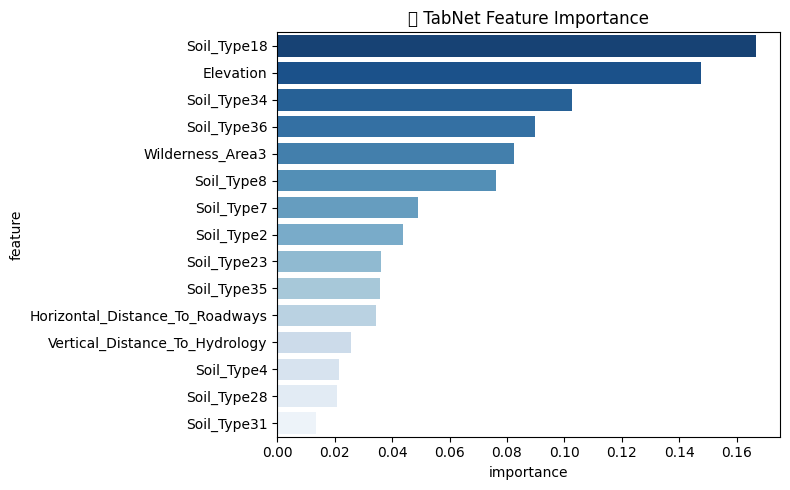

In [15]:
#Visualize TabNet feature importance
import seaborn as sns

feature_importances = tabnet.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=feat_imp_df, palette='Blues_r')
plt.title("🔍 TabNet Feature Importance")
plt.tight_layout()
plt.show()